<a href="https://colab.research.google.com/github/nicole-malaquias/adventureWorks/blob/main/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


A seguir, vamos tratar os dados e explorar alguns detalhes a respeito da demanda, a fim de responder às seguintes perguntas:

Previsão de Demanda para os Próximos 3 Meses: Para otimizar a distribuição de produtos e estimar com maior precisão a necessidade de compra de matéria-prima, realizaremos previsões da demanda para os próximos três meses de cada produto em cada loja. Durante esse processo, também investigaremos a presença de sazonalidade em produtos selecionados, identificando aqueles que apresentam padrões sazonais.

Abordagem de Modelos de Regressão: Avaliaremos se é possível resolver o problema de previsão de demanda utilizando modelos de regressão. Testaremos diferentes modelos de regressão e compararemos seus resultados utilizando métricas de avaliação apropriadas para identificar qual modelo apresenta o melhor desempenho nesse contexto específico.

Crescimento de Demanda em Centros de Distribuição: Com a criação de novos centros de distribuição, agora organizados por províncias nos EUA e por países no resto do mundo, analisaremos qual desses grupos apresentou maior crescimento de demanda nos três meses previstos, fornecendo insights valiosos para futuras decisões de expansão e alocação de recursos.

Estimativa de Zíperes para Produção de Luvas: Por fim, forneceremos uma estimativa da quantidade de zíperes necessários para a produção de luvas nos próximos três meses, considerando que cada par de luvas requer dois zíperes. Essa estimativa será essencial para que o novo fornecedor de luvas possa planejar sua produção de maneira eficiente.



# Configurações

## Instalações



In [6]:
!pip install optuna

In [7]:
!pip install google-cloud-bigquery
!pip install pandas-gbq
!pip install hierarchicalforecast
!pip install statsforecast

## Importes

In [8]:
import itertools
import pickle
from datetime import datetime

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from pylab import rcParams
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (accuracy_score, mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error, r2_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, OneHotEncoder, StandardScaler
from statsforecast import StatsForecast
from statsforecast.models import ARIMA, AutoARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp
from hierarchicalforecast.utils import aggregate

## Configurações Iniciais

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12
}
plt.rcParams.update(dark_style)

rcParams['figure.figsize'] = (12, 5)

## Parametros Globais

In [11]:
import os
os.environ['NIXTLA_ID_AS_COL'] = '1'

In [12]:
START_DATE= '2014-03-31'
END_DATE='2014-09-30'

## Funções Auxiliares

In [13]:
def validate_observations(df):
    """

    """
    # create a df to count the observations per store, product, and month
    count_df = df.groupby(['store_name', 'product_name']).size().reset_index(name='observations')

    # Check if each store and product has exactly 6 observations
    validation = count_df[count_df['observations'] != 6]

    if len(validation) == 0:
        print("All stores have 6 observations for each of the 28 products.")
    else:
        print(f"Stores with products missing observations:\n{validation}")
        print(f"Total number of stores/products with incorrect observations: {len(validation)}")

    return validation

In [14]:
def print_unique_counts(dataset):
    """
    Prints the number of unique values in the 'country_name', 'province_name',
    'store_name', and 'product_name' columns of the given dataset.
    """
    countries = dataset['country_name'].nunique()
    provinces = dataset['province_name'].nunique()
    stores = dataset['store_name'].nunique()
    products = dataset['product_name'].nunique()

    print(f"Quantidade de paises: {countries}")
    print(f"Quantidade de estados: {provinces}")
    print(f"Quantidade de lojas: {stores}")
    print(f"Quantidade de produtos: {products}")

In [15]:
def print_detailed_counts(dataset):
    """
    Prints detailed counts of unique provinces per country, unique stores per province
    within each country, and unique products per store in the given dataset.

    The function outputs:
    - The number of unique provinces in each country.
    - The number of unique stores in each province, separated by country.
    - The number of unique products in each store.
    """

    states_per_country = dataset.groupby('country_name')['province_name'].nunique()
    print("\nEstados por país:")
    for country, states in states_per_country.items():
        print(f"{country}: {states} estados")

    print("\nLojas por estado e país:")
    for country in dataset['country_name'].unique():
        print(f"\nPaís: {country}")
        provinces_in_country = dataset[dataset['country_name'] == country].groupby('province_name')['store_name'].nunique()
        for province, stores in provinces_in_country.items():
            print(f"  {province}: {stores} lojas")

    products_per_store = dataset.groupby('store_name')['product_name'].nunique()
    print("\nProdutos por loja:")
    for store, products in products_per_store.items():
        print(f"{store}: {products} produtos")

##  Load Data

In [16]:
df = pd.read_csv('/content/drive/MyDrive/Classroom/Colab Notebooks/agg_sales_forecast.csv')
df.head()

,country_name,province_name,store_name,product_name,finishedgoodsflag,standardcost,productnumber,total_qty,last_day_of_quarter
0,United States,Texas,The Gear Store,"Mountain Bike Socks, M",True,3.3963,SO-B909-M,26,2011-09-30
1,United States,Tennessee,Global Plaza,"Mountain Bike Socks, M",True,3.3963,SO-B909-M,32,2012-06-30
2,Canada,Ontario,Original Bicycle Supply Company,Cable Lock,True,10.3125,LO-C100,11,2012-06-30
3,Canada,Brunswick,Citywide Service and Repair,Cable Lock,True,10.3125,LO-C100,11,2012-06-30
4,Canada,British Columbia,Neighborhood Store,Cable Lock,True,10.3125,LO-C100,11,2012-09-30


A granularidade dos dados foi definida em trimestres, com cada observação representando um período de três meses, sempre marcada pela data do último dia do trimestre. Essa decisão foi tomada devido à necessidade de utilizar séries temporais hierarquizadas para a previsão de demanda, considerando as limitações de memória e tempo de processamento.

Optamos por dados trimestrais em vez de mensais para evitar um aumento significativo no volume de dados, que poderia sobrecarregar a capacidade de processamento e memória. Durante as análises, também foi observado que as séries temporais apresentavam desbalanceamento, com diferentes comprimentos entre as séries. Para uniformizar essas séries, foi necessário adicionar demandas zeradas nos períodos em que não havia observações.

Essa abordagem foi escolhida porque modelos como ARIMA, especialmente com sazonalidade, tendem a ter dificuldades ao lidar com frequentes zeros ou ausências de dados. Uma técnica estudada para melhorar a performance do modelo é a suavização, que considera o dado atual e os dois anteriores, sugerindo uma abordagem trimestral.

Portanto, a granularidade trimestral, com datas marcadas no último dia de cada trimestre, foi mantida para garantir que o modelo de machine learning pudesse ser executado de forma mais eficiente, reduzindo o tempo de processamento e melhorando a estabilidade do modelo.

# Pre Processamento

### Validação de Nulos

In [17]:
df.isna().sum() / df.shape[0] * 100

,0
country_name,0.0
province_name,0.0
store_name,0.0
product_name,0.0
finishedgoodsflag,0.0
standardcost,0.0
productnumber,0.0
total_qty,0.0
last_day_of_quarter,0.0


### Validação de tipos

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70649 entries, 0 to 70648
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country_name         70649 non-null  object 
 1   province_name        70649 non-null  object 
 2   store_name           70649 non-null  object 
 3   product_name         70649 non-null  object 
 4   finishedgoodsflag    70649 non-null  bool   
 5   standardcost         70649 non-null  float64
 6   productnumber        70649 non-null  object 
 7   total_qty            70649 non-null  int64  
 8   last_day_of_quarter  70649 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 4.4+ MB


## Filtro de linhas

### Amostra Dados por Periodo

Conforme mencionado anteriormente, os dados foram estruturados com granularidade trimestral, abrangendo o período de 30 de junho de 2011 a 31 de julho de 2014, com o objetivo de facilitar a previsão de demanda usando técnicas de machine learning.

Durante a modelagem do data warehouse, foi analisado que os dados disponíveis até 31 de julho de 2014 fazem parte do terceiro trimestre. Como os dados de 2014 não incluíam informações completas para todo o terceiro trimestre, foi decidido utilizar os dados disponíveis até 31 de julho de 2014 como referência para as vendas desse trimestre.

Dado que os dados sempre são marcados com a data do último dia do trimestre, os registros de 31 de julho de 2014 foram considerados como representativos do terceiro trimestre de 2014. Portanto, esses dados foram ajustados para o dia 30 de setembro de 2014, mantendo assim a consistência na análise e na agregação dos dados.

In [19]:
df = df.rename(columns={'last_day_of_quarter': 'date'})
df['date'] = pd.to_datetime(df['date'])
df.head(2)

,country_name,province_name,store_name,product_name,finishedgoodsflag,standardcost,productnumber,total_qty,date
0,United States,Texas,The Gear Store,"Mountain Bike Socks, M",True,3.3963,SO-B909-M,26,2011-09-30
1,United States,Tennessee,Global Plaza,"Mountain Bike Socks, M",True,3.3963,SO-B909-M,32,2012-06-30


In [20]:
print(f"Começo das datas do dataset {df['date'].min()}")
print(f"Fim das datas do dataset {df['date'].max()}")
df = df.loc[(df['date'] >= START_DATE) & (df['date'] <= END_DATE)]
full_range = df.copy()

Começo das datas do dataset 2011-06-30 00:00:00
Fim das datas do dataset 2014-09-30 00:00:00


### Filtrando apenas Lojas

In [21]:
df = df[df['store_name'] != 'Online Store']

In [22]:
df.shape

(11921, 9)

### Agrupando Produtos

Ao analisar os produtos, foi identificado que alguns itens com o mesmo prefixo no número do produto (product number), começam com o mesmo padrão de nome e compartilham o mesmo custo de produção. Com base nessa observação, esses itens foram agrupados como um único produto, sendo que as diferenças entre eles se restringem a detalhes menores. Essa abordagem tem o objetivo de melhorar o desempenho computacional do algoritmo de machine learning.

In [23]:
def process_product_data(df):
    # Extrair o prefixo do número do produto
    df['product_prefix'] = df['productnumber'].str[:7]

    # Truncar o nome do produto até a primeira vírgula
    df['product_name_truncated'] = df['product_name'].str.split(',').str[0]

    # Definir os campos relevantes para o agrupamento
    fields = ['country_name',
              'province_name',
              'store_name',
              'finishedgoodsflag',
              'standardcost',
              'product_prefix',
              'product_name_truncated',
              'date']

    # Agrupar por loja, produto e demais campos, mantendo as colunas relevantes
    resultado = df.groupby(
        fields,
        as_index=False
    ).agg({
        'total_qty': 'sum',
        'productnumber': 'first'
    })

    return resultado

In [24]:
df = process_product_data(df)
full_range = process_product_data(full_range)

## Ajustando Nomes das lojas

Dado que serão utilizadas Séries Temporais Hierárquicas (HTS), a adição de um prefixo ao nome da loja será implementada para evitar problemas de reconciliação, como a duplicidade de nomes de lojas em estados ou países diferentes. O prefixo será formado pela primeira letra do país e pela primeira letra do estado, assegurando a unicidade dos identificadores das lojas. Essa abordagem visa eliminar possíveis conflitos durante o processo de análise hierárquica, garantindo uma estrutura de dados mais consistente e precisa para o modelo.

In [25]:
def adicionar_prefixo(df, coluna_loja='store_name', coluna_pais='country_name', coluna_estado='province_name'):
    # Criar uma função para gerar o prefixo com a primeira letra do país e do estado
    def gerar_prefixo(row):
        primeira_letra_pais = row[coluna_pais][0].upper()
        primeira_letra_estado = row[coluna_estado][0].upper()
        return f"{primeira_letra_pais}{primeira_letra_estado}"

    # Aplicar a função para gerar o prefixo e adicionar ao nome da loja
    df['store_name'] = df.apply(lambda row: f"{gerar_prefixo(row)}_{row[coluna_loja]}", axis=1)

    return df

df = adicionar_prefixo(df)
df.head()

,country_name,province_name,store_name,finishedgoodsflag,standardcost,product_prefix,product_name_truncated,date,total_qty,productnumber
0,Australia,New South Wales,AN_Bike Part Wholesalers,True,1.8663,WB-H098,Water Bottle - 30 oz.,2014-03-31,3,WB-H098
1,Australia,New South Wales,AN_Bike Part Wholesalers,True,1.8663,WB-H098,Water Bottle - 30 oz.,2014-06-30,4,WB-H098
2,Australia,New South Wales,AN_Bike Part Wholesalers,True,2.9733,CL-9009,Bike Wash - Dissolver,2014-03-31,5,CL-9009
3,Australia,New South Wales,AN_Bike Part Wholesalers,True,2.9733,CL-9009,Bike Wash - Dissolver,2014-06-30,6,CL-9009
4,Australia,New South Wales,AN_Bike Part Wholesalers,True,6.9223,CA-1098,AWC Logo Cap,2014-03-31,4,CA-1098


In [26]:
df = df.drop(['standardcost', 'product_prefix','finishedgoodsflag','productnumber'], axis=1)
df = df.rename(columns={'product_name_truncated': 'product_name'})
df.head()

,country_name,province_name,store_name,product_name,date,total_qty
0,Australia,New South Wales,AN_Bike Part Wholesalers,Water Bottle - 30 oz.,2014-03-31,3
1,Australia,New South Wales,AN_Bike Part Wholesalers,Water Bottle - 30 oz.,2014-06-30,4
2,Australia,New South Wales,AN_Bike Part Wholesalers,Bike Wash - Dissolver,2014-03-31,5
3,Australia,New South Wales,AN_Bike Part Wholesalers,Bike Wash - Dissolver,2014-06-30,6
4,Australia,New South Wales,AN_Bike Part Wholesalers,AWC Logo Cap,2014-03-31,4


## Ajustando Produndidade

Para realizar a previsão utilizando a técnica de HTS, os dados precisam ter a mesma profundidade em todas as hierarquias. O código abaixo ajusta os dados para garantir que todas as lojas possuam todos os produtos presentes no dataset em todo os trimestres. Caso algum produto não tenha demanda registrada em uma determinada loja, o valor da demanda será atribuído como zero.

In [27]:
validate_observations(df)

Stores with products missing observations:
                    store_name              product_name  observations
0     AN_Bike Part Wholesalers              AWC Logo Cap             2
1     AN_Bike Part Wholesalers     Bike Wash - Dissolver             2
2     AN_Bike Part Wholesalers                     Chain             1
3     AN_Bike Part Wholesalers              Classic Vest             2
4     AN_Bike Part Wholesalers              Front Brakes             2
...                        ...                       ...           ...
4923          UW_Travel Sports   Women's Mountain Shorts             2
4924         UW_Two Bike Shops  ML Road Frame-W - Yellow             1
4925         UW_Two Bike Shops            Road-250 Black             1
4926         UW_Two Bike Shops         Road-550-W Yellow             1
4927           UW_Wingtip Toys   Women's Mountain Shorts             1

[4928 rows x 3 columns]
Total number of stores/products with incorrect observations: 4928


,store_name,product_name,observations
0,AN_Bike Part Wholesalers,AWC Logo Cap,2
1,AN_Bike Part Wholesalers,Bike Wash - Dissolver,2
2,AN_Bike Part Wholesalers,Chain,1
3,AN_Bike Part Wholesalers,Classic Vest,2
4,AN_Bike Part Wholesalers,Front Brakes,2
...,...,...,...
4923,UW_Travel Sports,Women's Mountain Shorts,2
4924,UW_Two Bike Shops,ML Road Frame-W - Yellow,1
4925,UW_Two Bike Shops,Road-250 Black,1
4926,UW_Two Bike Shops,Road-550-W Yellow,1


In [28]:
def fill_missing_data(df, store_id, quarterly_sequence):
    """
    Preenche os dados faltantes para uma loja específica no dataset, garantindo que todas as combinações de
    produtos e datas estejam presentes, e retorna um DataFrame consolidado com essas informações.

    A função filtra os dados para uma loja específica, gera todas as combinações possíveis de produtos e datas
    trimestrais, e mescla essas combinações com os dados existentes. Os valores de quantidade (`total_qty`) faltantes
    são preenchidos com 0. A função também remove duplicatas, priorizando as linhas onde a quantidade é maior que zero.
    """
    store_df = df[df['store_id'] == store_id]

    product = df['product_name'].unique()

    # cria todas as combinações possíveis de produto e data
    store_info = store_df[['country_name', 'province_name', 'store_name']].iloc[0]
    combination = pd.MultiIndex.from_product(
        [product, quarterly_sequence],
        names=['product_name', 'date']
    ).to_frame(index=False)

    combination['country_name'] = store_info['country_name']
    combination['province_name'] = store_info['province_name']
    combination['store_name'] = store_info['store_name']

    # mergia com os dados originais para preencher as demandas faltantes com 0
    merged_df = pd.merge(combination, store_df, on=['product_name', 'date', 'country_name', 'province_name', 'store_name'], how='left')

    # preenche total_qty faltante com 0
    merged_df['total_qty'] = merged_df['total_qty'].fillna(0)

    # tira duplicidade
    merged_df = merged_df.sort_values(by=['total_qty'], ascending=False)
    merged_df = merged_df.drop_duplicates(subset=['country_name', 'province_name', 'store_name', 'product_name', 'date'], keep='first')

    merged_df = merged_df[['country_name', 'province_name', 'store_name', 'product_name', 'date', 'total_qty']].sort_values(by=['product_name', 'date'])

    return merged_df


def master(df):
    """
    Preenche os dados faltantes para cada loja no dataset original e retorna um DataFrame consolidado.
    A função cria um identificador único para cada loja (`store_id`) combinando o nome do país,
    nome da província e nome da loja. Em seguida, para cada loja única, preenche os dados faltantes
    dentro do intervalo de datas especificado e retorna um DataFrame consolidado com todos os dados
    faltantes preenchidos.
    """

    # sequência trimestral
    quarterly_sequence = pd.date_range(start='2013-06-30', end='2014-09-30', freq='Q')

    df['store_id'] = df['country_name'] + '_' + df['province_name'] + '_' + df['store_name']

    dataset = []

    # filtra lojas únicas pelo 'store_id'
    unique_store = df['store_id'].unique()

    for store_id in unique_store:
        # preeche dados faltantes para a loja e adicionar ao dataset
        store_df = fill_missing_data(df, store_id, quarterly_sequence)
        dataset.append(store_df)

    df = pd.concat(dataset).reset_index(drop=True)
    return df

fill_df = master(df)

print(f"Número total de observações no dataset: {len(fill_df)}")
df = fill_df.copy()
df.head()

Número total de observações no dataset: 205128


,country_name,province_name,store_name,product_name,date,total_qty
0,Australia,New South Wales,AN_Bike Part Wholesalers,AWC Logo Cap,2013-06-30,0.0
1,Australia,New South Wales,AN_Bike Part Wholesalers,AWC Logo Cap,2013-09-30,0.0
2,Australia,New South Wales,AN_Bike Part Wholesalers,AWC Logo Cap,2013-12-31,0.0
3,Australia,New South Wales,AN_Bike Part Wholesalers,AWC Logo Cap,2014-03-31,4.0
4,Australia,New South Wales,AN_Bike Part Wholesalers,AWC Logo Cap,2014-06-30,3.0


In [29]:
validate_observations(df)

All stores have 6 observations for each of the 28 products.


,store_name,product_name,observations


# Momento Estatistico

A função **print_unique_counts** exibe uma visão geral do número de elementos únicos presentes em diferentes dimensões do df. Ela fornece uma contagem simples dos seguintes itens:

In [29]:
print_unique_counts(df)

Quantidade de paises: 6
Quantidade de estados: 62
Quantidade de lojas: 462
Quantidade de produtos: 74


Abaixo, apresentamos a quantidade total de lojas em cada país e uma visão mais detalhada, resultado da função print_detailed_counts. Esta função fornece uma análise macro sobre a distribuição de estados com lojas em cada país, bem como a quantidade de lojas em cada estado.

In [30]:
print_detailed_counts(df)


Estados por país:
Australia: 4 estados
Canada: 6 estados
France: 12 estados
Germany: 6 estados
United Kingdom: 1 estados
United States: 33 estados

Lojas por estado e país:

País: Australia
  New South Wales: 23 lojas
  Queensland: 1 lojas
  South Australia: 3 lojas
  Victoria: 6 lojas

País: Canada
  Alberta: 8 lojas
  British Columbia: 12 lojas
  Brunswick: 1 lojas
  Manitoba: 1 lojas
  Ontario: 34 lojas
  Quebec: 19 lojas

País: France
  Essonne: 2 lojas
  Garonne (Haute): 1 lojas
  Hauts de Seine: 6 lojas
  Loir et Cher: 2 lojas
  Loiret: 2 lojas
  Nord: 2 lojas
  Pas de Calais: 1 lojas
  Seine (Paris): 9 lojas
  Seine Saint Denis: 3 lojas
  Seine et Marne: 2 lojas
  Val d'Oise: 1 lojas
  Val de Marne: 1 lojas

País: Germany
  Bayern: 3 lojas
  Brandenburg: 1 lojas
  Hamburg: 7 lojas
  Hessen: 5 lojas
  Nordrhein-Westfalen: 5 lojas
  Saarland: 7 lojas

País: United Kingdom
  England: 34 lojas

País: United States
  Alabama: 3 lojas
  Arizona: 8 lojas
  California: 41 lojas
  Color

<Figure size 1500x1000 with 0 Axes>

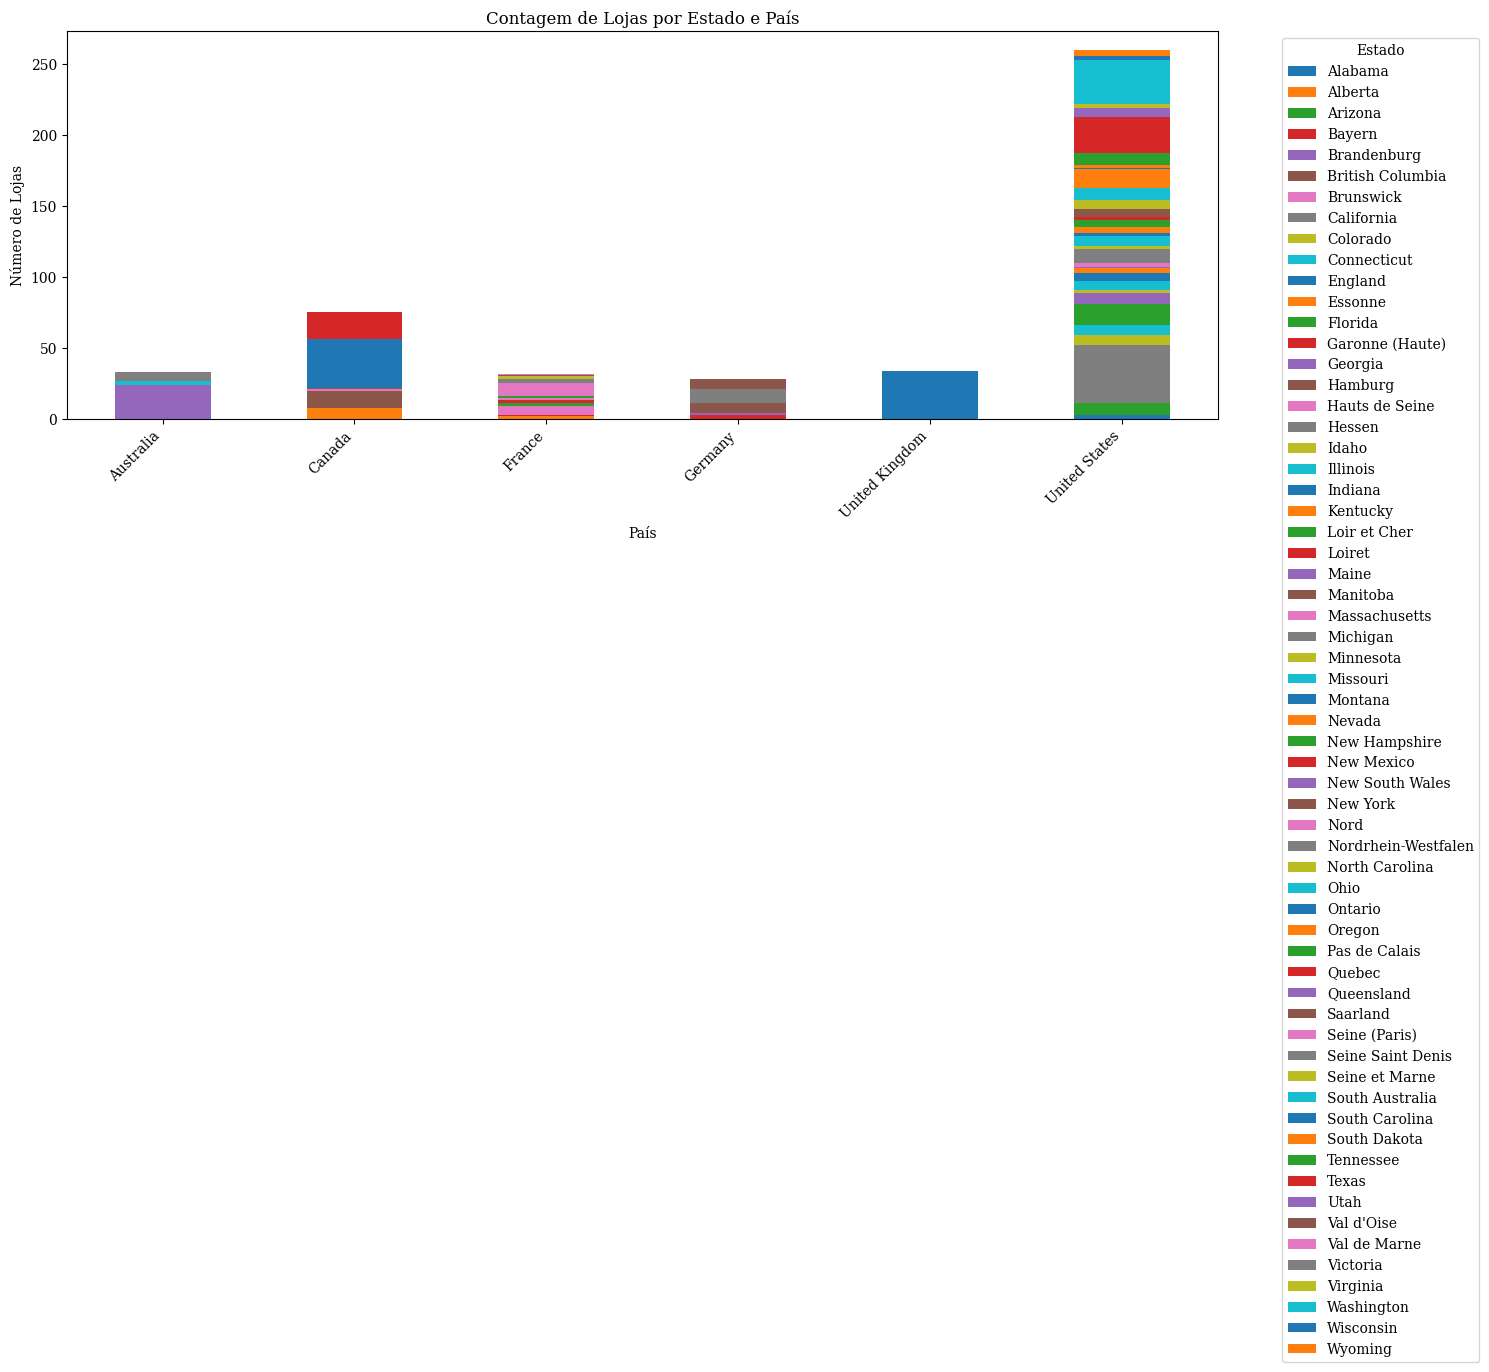

In [31]:
stores_per_province_country = df.groupby(['country_name', 'province_name'])['store_name'].nunique().unstack()

plt.figure(figsize=(15, 10))
stores_per_province_country.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title('Contagem de Lojas por Estado e País')
plt.xlabel('País')
plt.ylabel('Número de Lojas')
plt.legend(title='Estado', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Este trecho de código realiza uma análise descritiva da coluna total_qty (quantidade total) para cada estado ou província representado na coluna province_name

In [32]:
df.groupby('province_name')['total_qty'].describe()

,count,mean,std,min,25%,50%,75%,max
province_name,,,,,,,,
Alabama,1332.0,0.014264,0.195227,0.0,0.0,0.0,0.0,4.0
Alberta,3552.0,0.199887,1.569571,0.0,0.0,0.0,0.0,31.0
Arizona,3552.0,0.199043,1.570665,0.0,0.0,0.0,0.0,40.0
Bayern,1332.0,0.260511,1.749660,0.0,0.0,0.0,0.0,28.0
Brandenburg,444.0,0.121622,0.937593,0.0,0.0,0.0,0.0,11.0
...,...,...,...,...,...,...,...,...
Victoria,2664.0,0.158033,0.997268,0.0,0.0,0.0,0.0,16.0
Virginia,1332.0,0.253003,1.985624,0.0,0.0,0.0,0.0,32.0
Washington,13764.0,0.231982,1.715089,0.0,0.0,0.0,0.0,84.0


Pode se notar abaixo que a maioria das províncias apresenta médias muito próximas de zero, o que indica que, em média, a quantidade total vendida é baixa ou houve muitos períodos sem vendas (totalizando 0).

Um desvio padrão grande em relação à média sugere que há uma grande variabilidade nas vendas dentro dessa província. Ou seja, embora a média possa ser baixa, há ocasiões em que as vendas foram significativamente maiores (ou menores) do que a média.

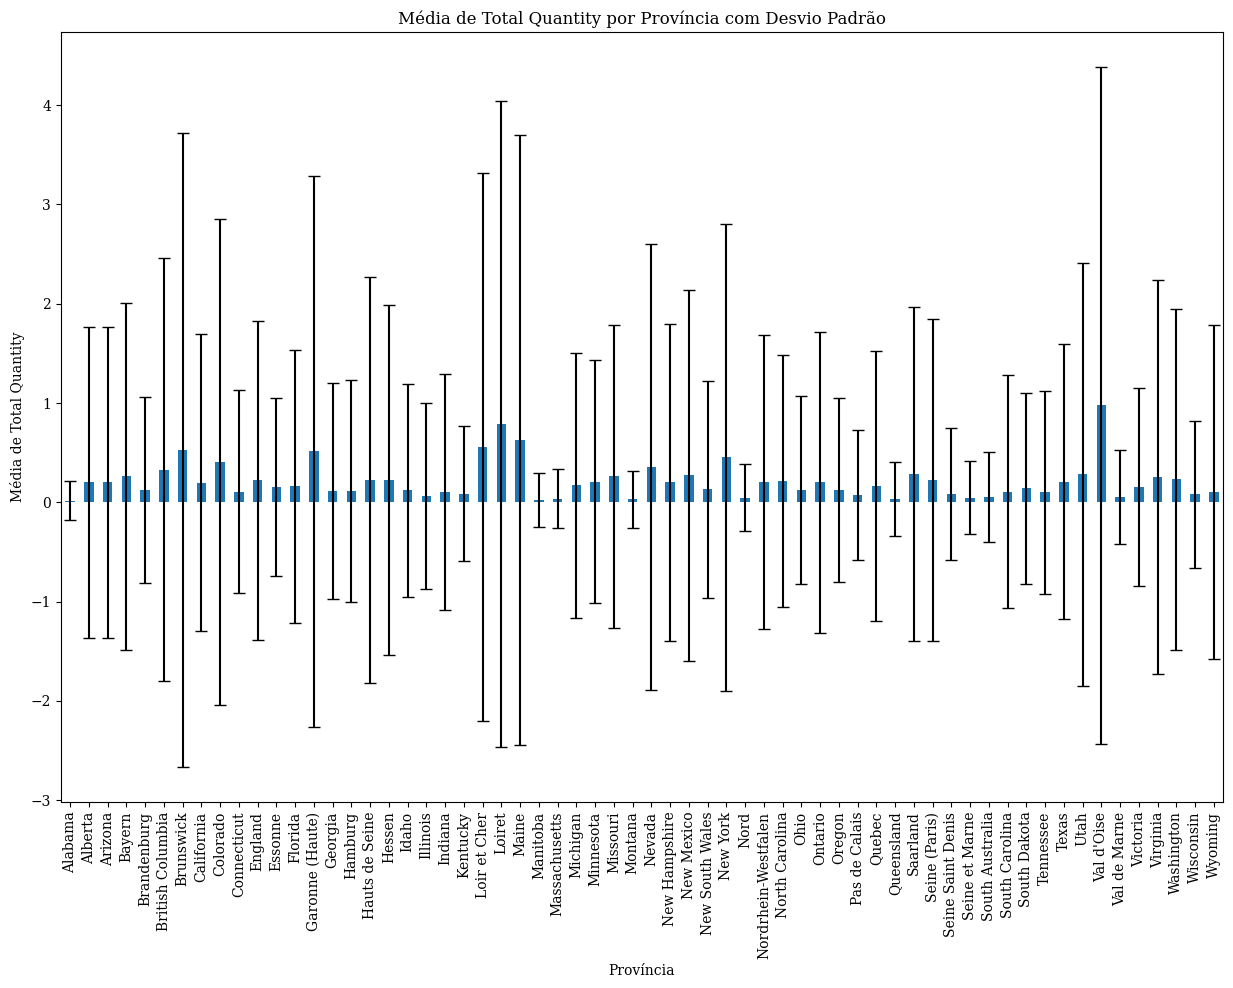

In [33]:
mean_std = df.groupby('province_name')['total_qty'].agg(['mean', 'std'])

# Gráfico de barras
plt.figure(figsize=(15, 10))
mean_std['mean'].plot(kind='bar', yerr=mean_std['std'], capsize=4)
plt.title('Média de Total Quantity por Província com Desvio Padrão')
plt.xlabel('Província')
plt.ylabel('Média de Total Quantity')
plt.xticks(rotation=90)
plt.show()


Validando se a série é estacionária

In [136]:
df['date'] = pd.to_datetime(df['date'])


def check_stationarity_hts(df):
    """Função que valida qual o percentual de séries estacionárias existem no dataset"""
    results = []
    grouped = df.groupby(['country_name', 'province_name', 'store_name', 'product_name'])

    for name, group in grouped:
        group = group.set_index('date').sort_index()
        if len(group['total_qty'].unique()) > 1:  # Verificar se há variabilidade suficiente na série
            result = adfuller(group['total_qty'], autolag='AIC')
            adf_stat, p_value = result[0], result[1]
            is_stationary = p_value <= 0.05
        else:
            adf_stat, p_value = None, None
            is_stationary = False

        results.append((name, adf_stat, p_value, is_stationary))

    return pd.DataFrame(results, columns=['Group', 'ADF Statistic', 'p-value', 'Stationary'])

stationarity_results_hts = check_stationarity_hts(df)

# Calcular a média de séries estacionárias e não estacionárias
total_series = len(stationarity_results_hts)
stationary_count = stationarity_results_hts['Stationary'].sum()
non_stationary_count = total_series - stationary_count

print(f"Total de séries temporais: {total_series}")
print(f"Séries estacionárias: {stationary_count} ({stationary_count / total_series:.2%})")
print(f"Séries não estacionárias: {non_stationary_count} ({non_stationary_count / total_series:.2%})")


Total de séries temporais: 34188
Séries estacionárias: 644 (1.88%)
Séries não estacionárias: 33544 (98.12%)


Essa informação é interessante, mas é importante considerar que uma das principais questões que precisamos responder é sobre a sazonalidade dos produtos. Aplicar técnicas para tornar as séries estacionárias, como a diferenciação ou a remoção de tendência, pode mascarar ou eliminar precisamente os padrões sazonais e as tendências que queremos analisar.

Validando se os dados de total_qty tem distribuição normal para quando for aplicado modelo de regressão o modelo performar melhor

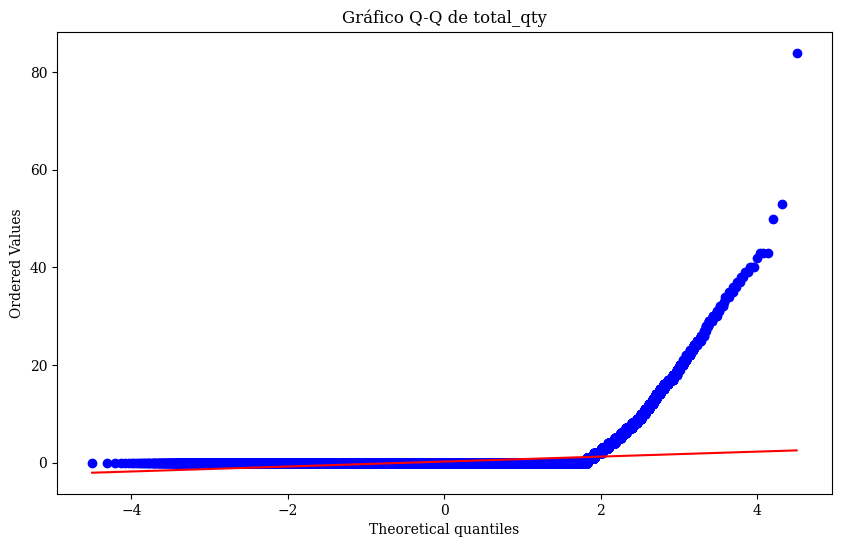

In [138]:
# Plotando o gráfico Q-Q
plt.figure(figsize=(10, 6))
stats.probplot(df['total_qty'], dist="norm", plot=plt)
plt.title('Gráfico Q-Q de total_qty')
plt.show()

O gráfico Q-Q indica que a variável total_qty não segue uma distribuição normal. Há evidências de caudas pesadas, especialmente na parte superior do gráfico, e a maioria dos dados está concentrada em valores muito baixos.


# Feature Enginner

In [31]:
df_r = df.copy()

In [32]:
df = df.rename(columns={'date': 'ds'
                        , 'total_qty': 'y'})
df.head()

,country_name,province_name,store_name,product_name,ds,y
0,Australia,New South Wales,AN_Bike Part Wholesalers,AWC Logo Cap,2013-06-30,0.0
1,Australia,New South Wales,AN_Bike Part Wholesalers,AWC Logo Cap,2013-09-30,0.0
2,Australia,New South Wales,AN_Bike Part Wholesalers,AWC Logo Cap,2013-12-31,0.0
3,Australia,New South Wales,AN_Bike Part Wholesalers,AWC Logo Cap,2014-03-31,4.0
4,Australia,New South Wales,AN_Bike Part Wholesalers,AWC Logo Cap,2014-06-30,3.0


In [33]:
hierarchy_levels = [
    ['country_name'],
    ['country_name', 'province_name'],
    ['country_name', 'province_name', 'store_name'],
    ['country_name', 'province_name', 'store_name', 'product_name']
]

Os dados abaixo serão tratados da seguinte forma:

**Y_hier_df**: DataFrame pandas com as séries temporais estruturadas hierarquicamente. Inclui colunas para unique_id (identifica cada série), ds (datas), e y (valores da série temporal).

**S_df**: DataFrame pandas que contém a matriz de soma, representando as restrições de agregação da hierarquia.

**tags**: Dicionário que mapeia cada nível hierárquico às suas respectivas tags, facilitando a identificação das séries em diferentes níveis."

In [34]:
Y_hier_df, S_df, tags = aggregate(df=df, spec=hierarchy_levels)

# Reseta o índice do df resultante para transformar o índice em coluna
Y_hier_df = Y_hier_df.reset_index()

# Converte a coluna 'ds' para o formato de data e hora
Y_hier_df['ds'] = pd.to_datetime(Y_hier_df['ds'])

# Preenche os valores faltantes na coluna 'y' com 0
Y_hier_df['y'] = Y_hier_df['y'].fillna(0)

In [35]:
df = Y_hier_df.copy()
df.head()

,unique_id,ds,y
0,Australia,2013-06-30,0.0
1,Australia,2013-09-30,0.0
2,Australia,2013-12-31,0.0
3,Australia,2014-03-31,734.0
4,Australia,2014-06-30,1102.0


# Separação de Treino e Teste  

Devido a limitações de capacidade computacional, foi necessário reduzir o volume dos dados. Como consequência dessa redução, ao aplicar a divisão tradicional em treino, validação e teste, o treinamento do modelo falha por conta da quantidade insuficiente de dados para cada conjunto. Diante dessa situação, para este experimento com séries temporais, decidi simplificar a abordagem, separando os dados apenas em treino e teste, garantindo assim a viabilidade do treinamento do modelo.


O uso de tail(1) no contexto de séries temporais hierárquicas (HTS) é uma abordagem lógica para garantir que o conjunto de teste contenha os dados mais recentes de cada série individual dentro do conjunto de dados hierárquico.

In [39]:
test_df = df.groupby('unique_id').tail(1)
train_df = df.drop(test_df.index)

# Ajustar o índice do conjunto de teste
test_df = test_df.set_index('unique_id')
train_df = train_df.set_index('unique_id')

In [40]:
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')
df.to_pickle('df.pkl')

#Tunning


O AutoARIMA foi utilizado para selecionar automaticamente os melhores parâmetros para o modelo ARIMA. Ele avalia diferentes combinações de parâmetros, como o número de diferenças (d), a ordem autorregressiva (p) e a média móvel (q), além de ajustar automaticamente a sazonalidade, se necessário. Esse processo de otimização garante que os parâmetros escolhidos sejam os mais adequados ao comportamento dos dados temporais, evitando a necessidade de testes manuais com diversas configurações.

In [ ]:
class ARIMAFineTuner:
    def __init__(self, pkl_file, chunk_size=10000):
        self.pkl_file = pkl_file
        self.chunk_size = chunk_size
        self.models = [AutoARIMA(season_length=12)]
        self.batch_results = []

    def tune(self):
        df = pd.read_pickle(self.pkl_file)
        total_rows = len(df)

        for i in tqdm(range(0, total_rows, self.chunk_size), desc="Tuning ARIMA models"):
            chunk = df.iloc[i:i + self.chunk_size]

            # Certifique-se de que 'unique_id' seja uma coluna, não o índice
            chunk = chunk.reset_index()

            # Passar o DataFrame diretamente para o método fit
            sf = StatsForecast(models=self.models, freq='Q', n_jobs=-1)
            sf = sf.fit(df=chunk)

            self.batch_results.append(sf)

        return self.batch_results

tuner = ARIMAFineTuner('train_df.pkl', chunk_size=10000)
batch_results = tuner.tune()

fitted_model = batch_results[0].fitted_[0, 0].model_
fitted_model

Tuning ARIMA models: 100%|██████████| 18/18 [14:00<00:00, 46.68s/it]


{'coef': {},
 'sigma2': 350632.0,
 'var_coef': None,
 'mask': array([], dtype=bool),
 'loglik': -39.013423964546334,
 'aic': 80.02684792909267,
 'arma': (0, 0, 0, 0, 1, 0, 0),
 'residuals': array([   0.,    0.,    0.,  734., 1102.]),
 'code': 0,
 'n_cond': 0,
 'nobs': 5,
 'model': {'phi': array([], dtype=float64),
  'theta': array([], dtype=float64),
  'delta': array([], dtype=float64),
  'Z': array([1.]),
  'a': array([1102.]),
  'P': array([[0.]]),
  'T': array([[0.]]),
  'V': array([[1.]]),
  'h': 0.0,
  'Pn': array([[1.]])},
 'bic': 79.63628584152677,
 'aicc': 81.360181262426,
 'ic': None,
 'xreg': None,
 'x': array([   0.,    0.,    0.,  734., 1102.]),
 'lambda': None}

O modelo AutoARIMA selecionou os parâmetros (0, 0, 0, 0, 1, 0, 0) como os melhores para obter um bom valor de AIC (Critério de Informação de Akaike). Esses parâmetros indicam a configuração específica do modelo ARIMA, que define como o modelo ajusta os dados de séries temporais, como a ordem de autorregressão, a diferenciação, e o número de médias móveis.

# Pipeline

O código foi desenvolvido para prever a demanda dos próximos 3 meses utilizando a granularidade de dados trimestral. Essa abordagem foi escolhida para acelerar o processo de treino e validação, já que o retreinamento mensal com dados preditos prolongaria significativamente o tempo de validação, podendo levar até 14 horas. Embora o uso do Spark pudesse ser uma alternativa mais rápida, o ambiente de laboratório apresentou instabilidade com as configurações do Spark. Por isso, optou-se pelo uso do pandas neste projeto MVP (Produto Mínimo Viável) , que tem como objetivo encontrar a forma mais eficaz de prever a demanda para a Adventure Works.

In [63]:
class ARIMABatchTrainer:
    def __init__(self, pkl_file, chunk_size=10000, h=1):
        self.pkl_file = pkl_file
        self.chunk_size = chunk_size
        self.h = h
        self.models = [ARIMA(order=(0, 0, 1), season_length=12)]
        self.df = pd.read_pickle(pkl_file).reset_index()
        self.total_rows = len(self.df)
        self.batch_results = []

    def train(self):
        for i in tqdm(range(0, self.total_rows, self.chunk_size), desc="Treinando modelos"):
            chunk = self.df.iloc[i:i + self.chunk_size]

            cst = StatsForecast(models=self.models, freq='Q', n_jobs=2)

            x_hat = cst.forecast(df=chunk, h=self.h)

            self.batch_results.append(x_hat)

            print(f'Previsões para o chunk {i // self.chunk_size + 1}')

        return self.batch_results

Esta seção carrega os dados de treinamento a partir de um arquivo .pkl, aplica os modelos ARIMA e Naive em lotes para otimizar o uso de memória, e gera previsões que são concatenadas e salvas para uso posterior.

In [44]:
pkl_file = 'train_df.pkl'

trainer = ARIMABatchTrainer(pkl_file=pkl_file, chunk_size=10000, h=1)

results = trainer.train()

y_pred_test = pd.concat(results)
y_pred_test.to_pickle('y_pred_test.pkl')

Treinando modelos:   6%|▌         | 1/18 [03:19<56:34, 199.66s/it]

Previsões para o chunk 1


Treinando modelos:  11%|█         | 2/18 [04:46<35:31, 133.24s/it]

Previsões para o chunk 2


Treinando modelos:  17%|█▋        | 3/18 [05:57<26:13, 104.92s/it]

Previsões para o chunk 3


Treinando modelos:  22%|██▏       | 4/18 [07:21<22:35, 96.79s/it] 

Previsões para o chunk 4


Treinando modelos:  28%|██▊       | 5/18 [08:28<18:36, 85.88s/it]

Previsões para o chunk 5


Treinando modelos:  33%|███▎      | 6/18 [09:33<15:44, 78.68s/it]

Previsões para o chunk 6


Treinando modelos:  39%|███▉      | 7/18 [10:45<14:03, 76.71s/it]

Previsões para o chunk 7


Treinando modelos:  44%|████▍     | 8/18 [11:42<11:44, 70.40s/it]

Previsões para o chunk 8


Treinando modelos:  50%|█████     | 9/18 [12:48<10:19, 68.86s/it]

Previsões para o chunk 9


Treinando modelos:  56%|█████▌    | 10/18 [13:53<09:02, 67.81s/it]

Previsões para o chunk 10


Treinando modelos:  61%|██████    | 11/18 [14:59<07:49, 67.13s/it]

Previsões para o chunk 11


Treinando modelos:  67%|██████▋   | 12/18 [16:02<06:34, 65.82s/it]

Previsões para o chunk 12


Treinando modelos:  72%|███████▏  | 13/18 [17:05<05:24, 64.98s/it]

Previsões para o chunk 13


Treinando modelos:  78%|███████▊  | 14/18 [18:07<04:17, 64.29s/it]

Previsões para o chunk 14


Treinando modelos:  83%|████████▎ | 15/18 [19:08<03:09, 63.25s/it]

Previsões para o chunk 15


Treinando modelos:  89%|████████▉ | 16/18 [20:19<02:11, 65.57s/it]

Previsões para o chunk 16


Treinando modelos:  94%|█████████▍| 17/18 [21:26<01:05, 65.85s/it]

Previsões para o chunk 17


Treinando modelos: 100%|██████████| 18/18 [22:01<00:00, 73.44s/it]

Previsões para o chunk 18


Neste trecho de código, será aplicando uma técnica chamada reconciliação hierárquica para ajustar as previsões do modelo em uma estrutura hierárquica, como previsões de vendas em diferentes níveis.

A reconciliação garante que as previsões em diferentes níveis da hierarquia sejam consistentes entre si. Por exemplo, a soma das previsões de vendas para todas as lojas de um estado deve ser igual à previsão total para o estado.




In [45]:
reconcilers = [
    BottomUp()
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_test = hrec.reconcile( Y_hat_df=y_pred_test
                          , S=S_df
                          , tags=tags)

Y_rec_test.to_pickle('Y_rec_test.pkl')

In [47]:
Y_rec_test.head()

,index,ds,ARIMA,index/BottomUp,ARIMA/BottomUp
unique_id,,,,,
Australia,0,2014-09-30,10.229065,1569901.0,178.571381
Canada,1508,2014-09-30,1377.632202,5661075.0,524.005127
France,1590,2014-09-30,924.064880,2258624.0,371.094360
Germany,1635,2014-09-30,603.881409,2065636.0,216.871399
United Kingdom,1670,2014-09-30,779.792542,2628262.0,279.542664


Neste trecho de código, está avaliando a precisão das previsões feitas pelo modelo utilizando métricas de erro.

A avaliação é realizada para entender o quão bem as previsões ajustadas pelo modelo se alinham com os valores reais. Isso ajuda a identificar a eficácia do modelo em prever corretamente os dados em diferentes níveis da hierarquia.



In [50]:
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

evaluator = HierarchicalEvaluation(evaluators=[mse, mae, rmse])
evaluator.evaluate(Y_hat_df=Y_rec_test
                   , Y_test_df=test_df
                   , tags=tags
                   , benchmark='ARIMA')

index  \
level                                              metric                        
Overall                                            mse-scaled      1340.501429   
                                                   mae-scaled      1577.153783   
                                                   rmse-scaled       36.612859   
country_name                                       mse-scaled         0.440451   
                                                   mae-scaled         0.920123   
                                                   rmse-scaled        0.663665   
country_name/province_name                         mse-scaled        47.547339   
                                                   mae-scaled        14.080817   
                                                   rmse-scaled        6.895458   
country_name/province_name/store_name              mse-scaled     17934.638798   
                                                   mae-scaled       418.580873   
                                                   rmse-scaled       133.92027   
country_name/province_name/store_name/product_name mse-scaled   2425997.451677   
                                                   mae-scaled      9496.168781   
                                                   rmse-scaled      1557.56138   

                                                               ARIMA  \
level                                              metric              
Overall                                            mse-scaled    1.0   
                                                   mae-scaled    1.0   
                                                   rmse-scaled   1.0   
country_name                                       mse-scaled    1.0   
                                                   mae-scaled    1.0   
                                                   rmse-scaled   1.0   
country_name/province_name                         mse-scaled    1.0   
                                                   mae-scaled    1.0   
                                                   rmse-scaled   1.0   
country_name/province_name/store_name              mse-scaled    1.0   
                                                   mae-scaled    1.0   
                                                   rmse-scaled   1.0   
country_name/province_name/store_name/product_name mse-scaled    1.0   
                                                   mae-scaled    1.0   
                                                   rmse-scaled   1.0   

                                                                 index/BottomUp  \
level                                              metric                         
Overall                                            mse-scaled    13714421.86527   
                                                   mae-scaled       6142.609675   
                                                   rmse-scaled      3703.298782   
country_name                                       mse-scaled   13965577.865332   
                                                   mae-scaled       3783.000841   
                                                   rmse-scaled      3737.054705   
country_name/province_name                         mse-scaled   11273932.234635   
                                                   mae-scaled       4441.809541   
                                                   rmse-scaled      3357.667678   
country_name/province_name/store_name              mse-scaled   41832035.510314   
                                                   mae-scaled      17727.505711   
                                                   rmse-scaled      6467.768975   
country_name/province_name/store_name/product_name mse-scaled    2425997.451677   
                                                   mae-scaled       9496.168781   
                                                   rmse-scaled       1557.56138   

                                         

A análise revela que o ARIMA com abordagem Bottom-Up apresenta uma performance notável nas hierarquias mais elevadas, como província e país, onde as agregações contribuem significativamente para melhorar a precisão das previsões. No entanto, em níveis mais granulares, como loja e produto, essa eficácia diminui, tornando o Bottom-Up menos eficiente. Ainda assim, mesmo com essa queda em níveis mais detalhados, o ARIMA com Bottom-Up continua sendo mais eficaz do que o ARIMA aplicado de forma isolada, oferecendo uma vantagem geral na modelagem de séries temporais hierárquicas.

A seguir, será feita uma junção entre os datasets com os valores preditos (y_pred) e os valores reais (test_df). Isso permite comparar os valores reais com os preditos, além de verificar se os índices (ds e unique_id) estão alinhados corretamente entre os dois datasets.

In [53]:
merged_results = pd.merge(left=test_df
                          , right=y_pred_test
                          , on=['ds', 'unique_id'])
merged_results.head()

,ds,unique_id,y,ARIMA
0,2014-09-30,Australia,0.0,10.229065
1,2014-09-30,Canada,0.0,1377.632202
2,2014-09-30,France,0.0,924.064880
3,2014-09-30,Germany,0.0,603.881409
4,2014-09-30,United Kingdom,0.0,779.792542


Junção de treino com dados preditos

In [61]:
y_pred_test = pd.read_pickle('y_pred_test.pkl')
test_df = pd.read_pickle('test_df.pkl')
test_temp = test_df.copy()
test_temp['y'] = y_pred_test['ARIMA'].values
combined_df = pd.concat([train_df, test_temp])
combined_df.to_pickle('combined_df.pkl')
combined_df.head()

,ds,y
unique_id,,
Australia,2013-06-30,0.0
Australia,2013-09-30,0.0
Australia,2013-12-31,0.0
Australia,2014-03-31,734.0
Australia,2014-06-30,1102.0


Os dados preditivos estão sendo usados para testar o modelo treinado, e em seguida, será realizada a previsão para o próximo trimestre.

In [64]:
pkl_file = 'combined_df.pkl'

trainer = ARIMABatchTrainer(pkl_file=pkl_file, chunk_size=10000, h=1)
results = trainer.train()

# predição de dados que não existem no dw
y_pred_future = pd.concat(results)
y_pred_future.to_pickle('y_pred_future.pkl')

Treinando modelos:   5%|▍         | 1/21 [01:34<31:39, 94.97s/it]

Previsões para o chunk 1


Treinando modelos:  10%|▉         | 2/21 [02:33<23:21, 73.77s/it]

Previsões para o chunk 2


Treinando modelos:  14%|█▍        | 3/21 [03:35<20:27, 68.18s/it]

Previsões para o chunk 3


Treinando modelos:  19%|█▉        | 4/21 [04:38<18:44, 66.15s/it]

Previsões para o chunk 4


Treinando modelos:  24%|██▍       | 5/21 [05:36<16:50, 63.16s/it]

Previsões para o chunk 5


Treinando modelos:  29%|██▊       | 6/21 [06:37<15:37, 62.51s/it]

Previsões para o chunk 6


Treinando modelos:  33%|███▎      | 7/21 [07:43<14:51, 63.65s/it]

Previsões para o chunk 7


Treinando modelos:  38%|███▊      | 8/21 [08:46<13:44, 63.45s/it]

Previsões para o chunk 8


Treinando modelos:  43%|████▎     | 9/21 [09:49<12:38, 63.22s/it]

Previsões para o chunk 9


Treinando modelos:  48%|████▊     | 10/21 [10:52<11:36, 63.36s/it]

Previsões para o chunk 10


Treinando modelos:  52%|█████▏    | 11/21 [11:52<10:20, 62.03s/it]

Previsões para o chunk 11


Treinando modelos:  57%|█████▋    | 12/21 [12:52<09:14, 61.65s/it]

Previsões para o chunk 12


Treinando modelos:  62%|██████▏   | 13/21 [13:58<08:22, 62.81s/it]

Previsões para o chunk 13


Treinando modelos:  67%|██████▋   | 14/21 [15:00<07:17, 62.50s/it]

Previsões para o chunk 14


Treinando modelos:  71%|███████▏  | 15/21 [16:38<07:20, 73.38s/it]

Previsões para o chunk 15


Treinando modelos:  76%|███████▌  | 16/21 [17:44<05:55, 71.18s/it]

Previsões para o chunk 16


Treinando modelos:  81%|████████  | 17/21 [18:50<04:38, 69.51s/it]

Previsões para o chunk 17


Treinando modelos:  86%|████████▌ | 18/21 [20:43<04:08, 82.77s/it]

Previsões para o chunk 18


Treinando modelos:  90%|█████████ | 19/21 [22:54<03:14, 97.22s/it]

Previsões para o chunk 19


Treinando modelos:  95%|█████████▌| 20/21 [25:04<01:46, 106.83s/it]

Previsões para o chunk 20


Treinando modelos: 100%|██████████| 21/21 [26:50<00:00, 76.69s/it] 

Previsões para o chunk 21


Reconciliation

In [66]:
y_pred_future = pd.read_pickle('y_pred_future.pkl')
combined_df = pd.read_pickle('combined_df.pkl')

In [67]:
reconcilers = [
    BottomUp()
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_future = hrec.reconcile( Y_hat_df=y_pred_future
                            , S=S_df
                            , tags=tags)

In [68]:
Y_rec_future.to_pickle('Y_rec_future.pkl')
Y_rec_future = pd.read_pickle('Y_rec_future.pkl')

Fazendo a junção de todos os dados preditos com os existentes

# Previsão de Demanda para os Próximos 3 Meses por Loja e Produto para Otimização da Distribuição e Estimativa de Matéria-Prima

Abaixo será tratado os dados para que fiquem mais faceis de compreender como está a predição.

In [ ]:
Y_rec_future_filtered = Y_rec_future[Y_rec_future['ds'] == '2014-12-31']
Y_rec_future_filtered = Y_rec_future_filtered.reset_index()

Y_rec_future_filtered[['country_name', 'province_name', 'store_name', 'product_name']] = Y_rec_future_filtered['unique_id'].str.split('/', expand=True)

Y_rec_future_filtered.drop(columns=['unique_id'], inplace=True)
Y_rec_future_filtered.head()

In [79]:
demand = Y_rec_future_filtered[(Y_rec_future_filtered['ds'] == '2014-12-31')
                    & (Y_rec_future_filtered['store_name'].notnull())
                    & (Y_rec_future_filtered['product_name'].notnull())]

demand = demand.rename(columns=
                    {'ARIMA/BottomUp': 'total_qty'
                    , 'ds': 'date'}).drop(columns=['ARIMA'])

Abaixo está a predição para as demandas dos produtos para cada loja.

In [80]:
demand['total_qty'] = demand['total_qty'].apply(lambda x: 0 if x < 0.5 else x)


,index,date,index/BottomUp,total_qty,country_name,province_name,store_name,product_name
530,3,2014-12-31,3.0,0.0,Australia,New South Wales,AN_Bike Part Wholesalers,AWC Logo Cap
531,4,2014-12-31,4.0,0.0,Australia,New South Wales,AN_Bike Part Wholesalers,Bike Wash - Dissolver
532,5,2014-12-31,5.0,0.0,Australia,New South Wales,AN_Bike Part Wholesalers,Chain
533,6,2014-12-31,6.0,0.0,Australia,New South Wales,AN_Bike Part Wholesalers,Classic Vest
534,7,2014-12-31,7.0,0.0,Australia,New South Wales,AN_Bike Part Wholesalers,Front Brakes


Abaixo está um gráfico que representa o total previsto para os próximos três meses, considerando todas as lojas e províncias em cada país.

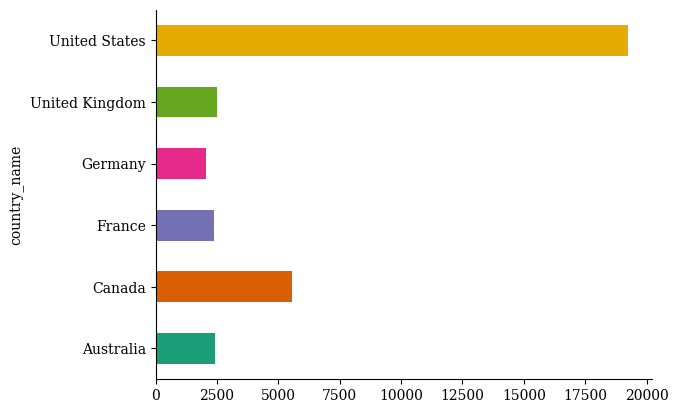

In [90]:
demand.groupby('country_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Abaixo estão os gráficos que mostram as previsões para cada província em cada país.









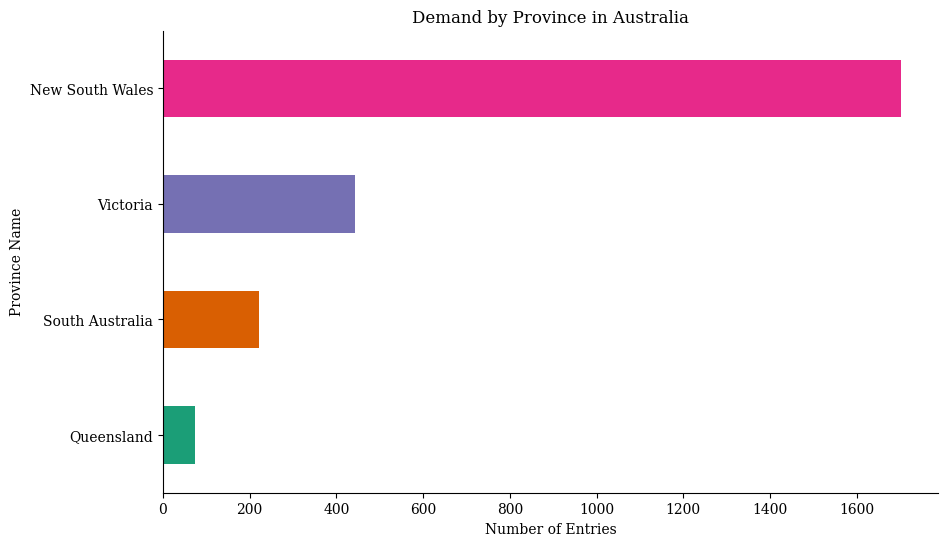

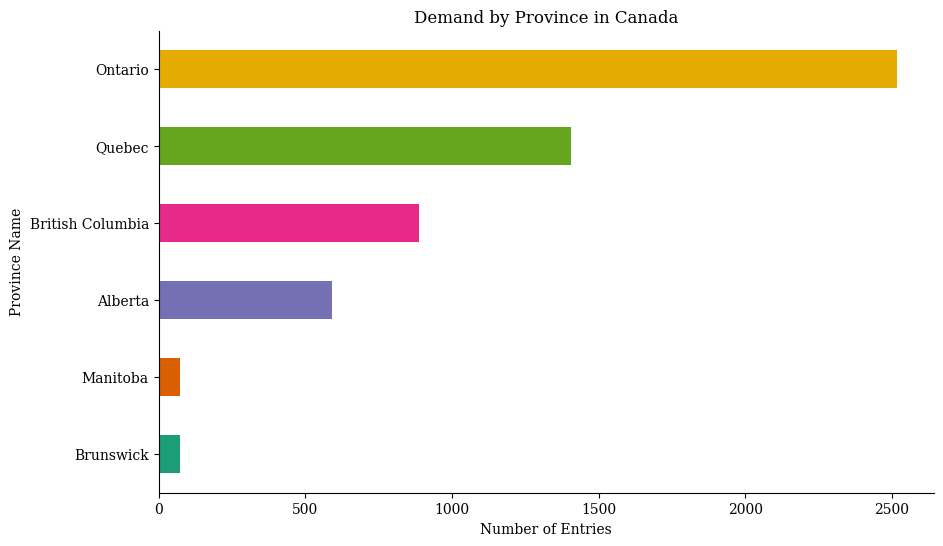

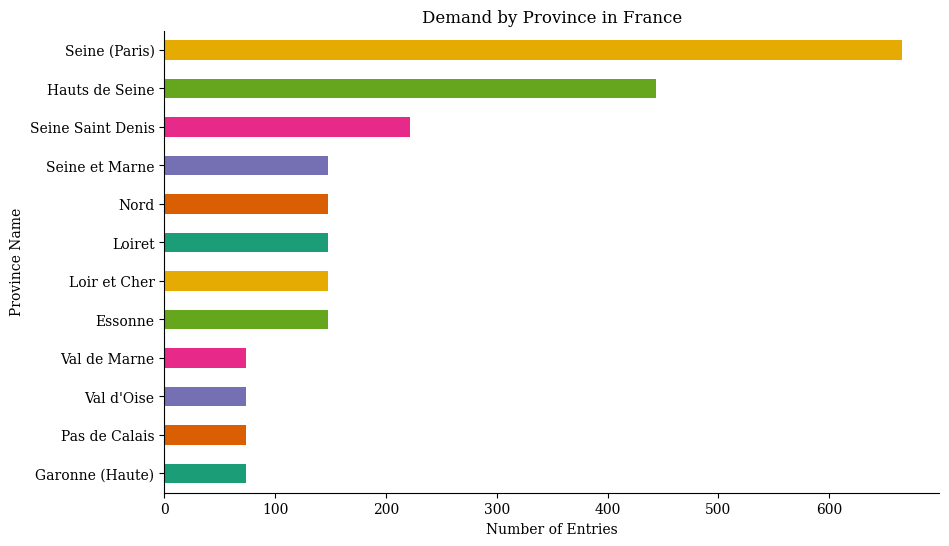

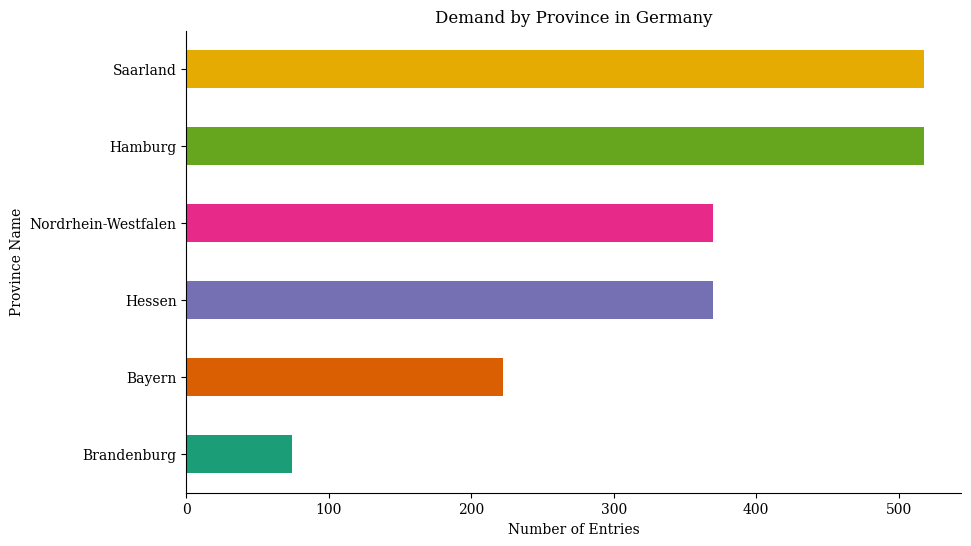

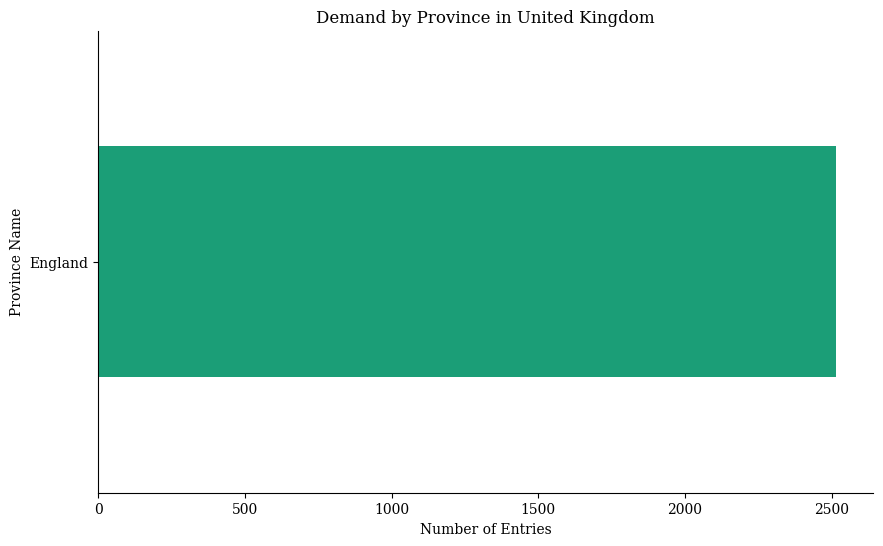

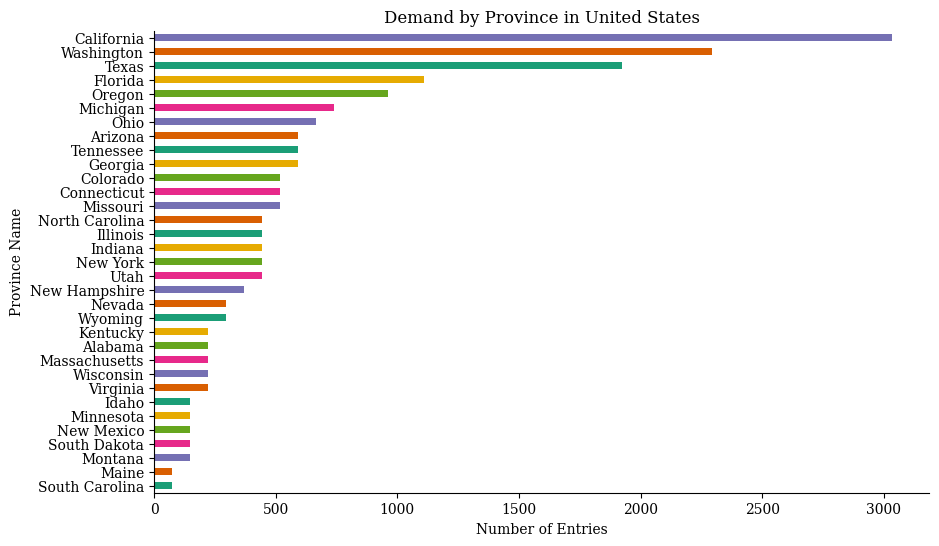

In [88]:
grouped_data = demand.groupby(['country_name', 'province_name']).size().reset_index(name='count')

# Plotando o gráfico para cada país
for country in grouped_data['country_name'].unique():
    plt.figure(figsize=(10, 6))
    data_to_plot = grouped_data[grouped_data['country_name'] == country]
    data_to_plot = data_to_plot.set_index('province_name').sort_values(by='count', ascending=True)

    data_to_plot['count'].plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
    plt.title(f'Demand by Province in {country}')
    plt.xlabel('Number of Entries')
    plt.ylabel('Province Name')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.show()

## Análise da Sazonalidade no Produto de Maior Demanda

Analisando se Há Sazonalidade no Produto com mais Demanda.

A seguir será filtrado o produto mais comprado no último trimestre, filtra dos dados completos de 2011 á 2014, cria uma série temporal com base nas vendas mensais e realiza uma decomposição sazonal para analisar a sazonalidade do produto.

Se as observações mostram um padrão repetitivo que ocorre em intervalos regulares (neste caso, possivelmente a cada quatro trimestres), é provável que exista sazonalidade no seu produto. Com 14 observações de 14 trimestres, é posssivel ter três ciclos completos (se a sazonalidade for anual), é suficiente para detectar padrões sazonais básicos.

O produto mais vendido de 2011 a 2014 foi 'Sport-100 Helmet' com um total de 19541 unidades.


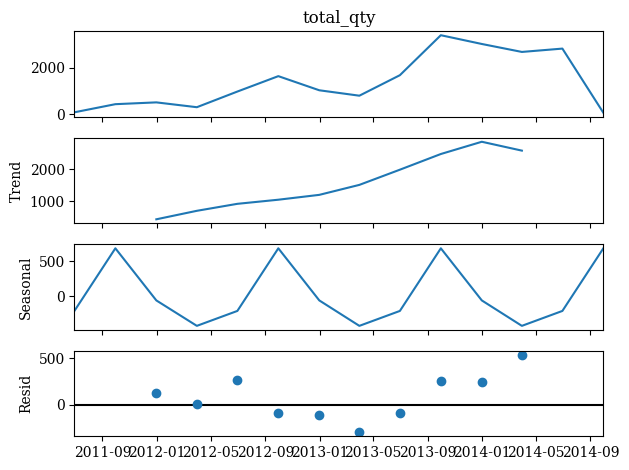

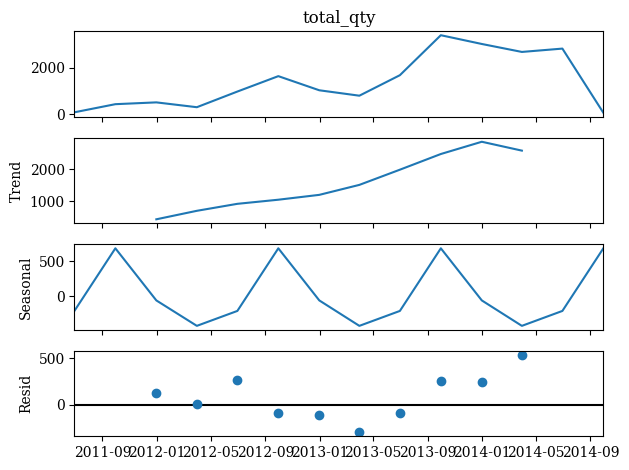

In [ ]:
filtered_df = full_range[(full_range['date'] >= '2011-06-30') & (full_range['date'] <= '2014-09-30')]

product_sales = filtered_df.groupby('product_name_truncated')['total_qty'].sum()

# o produto mais vendido entre 2011 e 2014
most_purchased_product = product_sales.idxmax()
most_purchased_qty = product_sales.max()

print(f"O produto mais vendido de 2011 a 2014 foi '{most_purchased_product}' com um total de {most_purchased_qty} unidades.")

# filtrando os dados completos do produto mais comprado
product_df = full_range[full_range['product_name_truncated'] == most_purchased_product]

product_ts = product_df.groupby('date')['total_qty'].sum()

product_ts = product_ts.asfreq('Q')

decomposition = seasonal_decompose(product_ts, model='additive', period=4)
decomposition.plot()

Acima está a decomposição da série temporal do produto 'AWC Logo Cap'

**Componente Sazonal**

Com base na decomposição da série temporal do produto 'AWC Logo Cap', há uma presença clara de sazonalidade. O componente sazonal mostra um padrão repetitivo de aumento e queda nas vendas ao longo dos anos. Esses ciclos sugerem que a demanda por esse produto tende a variar de forma previsível em determinados períodos, com picos e quedas ocorrendo em intervalos regulares.

Portanto, a sazonalidade está presente e é significativa para o 'AWC Logo Cap', permitindo à empresa usar essa informação para planejar suas campanhas de vendas e estratégias de estoque de forma mais eficiente.

# Avaliação da Aplicabilidade de Modelos de Regressão para Solução do Problema e Comparação de Desempenho

## Separando em treino e teste

In [36]:
train_df = df_r[df_r['date'] <= '2014-03-31']
X_train = train_df.drop(columns=['total_qty'])
y_train = train_df['total_qty']

validation_df = df_r[df_r['date'] == '2014-06-30']
X_validation = validation_df.drop(columns=['total_qty'])
y_validation = validation_df['total_qty']

test_df = df_r[df_r['date'] == '2014-09-30']
X_test = test_df.drop(columns=['total_qty'])
y_test = test_df['total_qty']

### Normalização de dados

In [37]:
categorical_columns = ['country_name', 'province_name', 'store_name']

numeric_columns = X_train.select_dtypes(include=[float, int]).columns.tolist()

# data_transformer com as colunas presentes
data_transformer = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(), categorical_columns),
    ('scaler', StandardScaler(), numeric_columns)
])

pipe = Pipeline(steps=[
    ('data_transformer', data_transformer),
    ('estimator', LinearRegression())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('data_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  ['country_name',
                                                   'province_name',
                                                   'store_name']),
                                                 ('scaler', StandardScaler(),
                                                  [])])),
                ('estimator', LinearRegression())])

### Tunning

In [38]:
def objective(trial):
    # Sugere se o scaler será usado ou não
    use_scaling = trial.suggest_categorical("use_scaling", [True, False])

    if use_scaling:
        data_transformer = ColumnTransformer([
            ('OneHotEncoder', OneHotEncoder(), categorical_columns),
            ('scaler', StandardScaler(), numeric_columns)
        ])
    else:
        data_transformer = ColumnTransformer([
            ('OneHotEncoder', OneHotEncoder(), categorical_columns)
        ])

    pipe = Pipeline(steps=[
        ('data_transformer', data_transformer),
        ('estimator', LinearRegression())
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_validation)

    # Cálculo das métricas
    r2 = r2_score(y_validation, y_pred)

    # Foca no R²
    return r2

In [39]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Resultados da melhor trial
trial = study.best_trial
print(f"Best trial R²: {trial.value}")
print("Best trial params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")


[I 2024-09-01 17:20:49,990] A new study created in memory with name: no-name-6f0f0e30-035a-4495-8bd6-4891874aea67
[I 2024-09-01 17:20:50,203] Trial 0 finished with value: -0.00504970923350645 and parameters: {'use_scaling': True}. Best is trial 0 with value: -0.00504970923350645.
[I 2024-09-01 17:20:50,439] Trial 1 finished with value: -0.00504970923350645 and parameters: {'use_scaling': False}. Best is trial 0 with value: -0.00504970923350645.
[I 2024-09-01 17:20:50,657] Trial 2 finished with value: -0.00504970923350645 and parameters: {'use_scaling': True}. Best is trial 0 with value: -0.00504970923350645.
[I 2024-09-01 17:20:50,879] Trial 3 finished with value: -0.00504970923350645 and parameters: {'use_scaling': False}. Best is trial 0 with value: -0.00504970923350645.
[I 2024-09-01 17:20:51,106] Trial 4 finished with value: -0.00504970923350645 and parameters: {'use_scaling': False}. Best is trial 0 with value: -0.00504970923350645.


Best trial R²: -0.00504970923350645
Best trial params: 
use_scaling: True


### Cross Validation

In [44]:
def cross_validation_score(pipe, train, target_column='total_qty', date_column='date'):
    r2_fit_scores = []
    mae_scores = []
    mape_scores = []
    rmse_scores = []

    unique_dates = train[date_column].unique()

    for i in range(len(unique_dates) - 1):
        # Define os conjuntos de treino e teste
        train_end_date = unique_dates[i]
        test_start_date = unique_dates[i + 1]

        train_set = train[train[date_column] <= train_end_date]
        test_set = train[train[date_column] == test_start_date]

        # Prepara os dados de treino e teste
        X_train = train_set.drop(columns=[target_column, date_column])
        y_train = train_set[target_column]

        X_test = test_set.drop(columns=[target_column, date_column])
        y_test = test_set[target_column]

        # Treina e faz predições
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        # Calcula as métricas
        r2 = r2_score(y_test, y_pred)
        mae_fold = mean_absolute_error(y_test, y_pred)
        mape_fold = mean_absolute_percentage_error(y_test, y_pred)
        rmse_fold = mean_squared_error(y_test, y_pred, squared=False)

        # Armazena as métricas
        r2_fit_scores.append(r2)
        mae_scores.append(mae_fold)
        mape_scores.append(mape_fold)
        rmse_scores.append(rmse_fold)

    # Calcula as métricas médias
    mean_r2_fit = np.mean(r2_fit_scores)
    mean_mae = np.mean(mae_scores)
    mean_mape = np.mean(mape_scores)
    mean_rmse = np.mean(rmse_scores)

    # Retorna as métricas médias
    return {'r2': mean_r2_fit, 'mae': mean_mae, 'mape': mean_mape, 'rmse': mean_rmse}


In [45]:
resultados = cross_validation_score(pipe, train_df, target_column='total_qty', date_column='date')

# Para visualizar os resultados
print("R2 Score:", resultados['r2'])
print("MAE:", resultados['mae'])
print("MAPE:", resultados['mape'])
print("RMSE:", resultados['rmse'])

R2 Score: 0.6489860680062837
MAE: 0.19615069615069614
MAPE: 0.0340957840957841
RMSE: 0.8739841324922689


### Rodando o modelo

In [47]:
pipe.fit(X_train, y_train)

# Validação
y_pred = pipe.predict(X_validation)

r2_predict = r2_score(y_validation, y_pred)
mae = mean_absolute_error(y_validation, y_pred)
mape = mean_absolute_percentage_error(y_validation, y_pred)

print(f"R2 Score: {r2_predict}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

# Teste
y_pred = pipe.predict(X_test)

r2_predict = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R2 Score: {r2_predict}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

R2 Score: -0.00504970923350645
MAE: 0.693494685897352
MAPE: 547649709567662.1
R2 Score: 0.0
MAE: 0.14711324180517435
MAPE: 662539140975048.9


Comparação das Métricas de Avaliação

**Modelo ARIMA HTS:**

MSE (Mean Squared Error): Essa métrica mede o erro médio ao quadrado entre as previsões e os valores reais. Valores menores indicam melhor desempenho. Os valores de MSE variam conforme o nível da hierarquia, mas o valor geral é 1340.501429, que é relativamente baixo em comparação com os valores dos níveis mais detalhados.

MAE (Mean Absolute Error): Mede o erro absoluto médio. Um MAE menor indica uma melhor precisão. No nível mais detalhado (produto em cada loja), o MAE é 9496.168781, o que mostra um erro considerável, mas compreensível devido ao nível de granularidade.

RMSE (Root Mean Squared Error): Uma métrica que dá mais peso a grandes erros, já que é a raiz quadrada da MSE. O RMSE geral é 36.612859, o que indica que o modelo tende a errar por cerca de 37 unidades, em média.


**Modelo de Regressão:**


R² Score: Avalia a proporção da variabilidade dos dados que é explicada pelo modelo. Um valor negativo de R² (-0.0050) sugere que o modelo de regressão não é eficaz e pode ser pior do que simplesmente prever a média.

MAE: O MAE para o modelo de regressão é 0.693494685897352 (primeiro R² Score), o que é bem menor do que no modelo ARIMA HTS. No entanto, isso pode ser devido ao nível de agregação dos dados.

MAPE (Mean Absolute Percentage Error): Mede o erro percentual médio. Valores extremamente altos (547649709567662.1) indicam que o modelo de regressão pode estar errando significativamente, especialmente em valores baixos de demanda.

Sim, é possível usar uma abordagem de regressão para resolver o problema, mas o modelo de regressão analisado aqui demonstra um desempenho inferior ao modelo ARIMA HTS. O ARIMA HTS é mais adequado porque é projetado para capturar padrões temporais e pode lidar com a estrutura hierárquica dos dados, algo que é crucial para previsões de demanda em diferentes níveis (país, província, loja, produto).

Portanto, para a tarefa de previsão de demanda para os próximos 3 meses, especialmente se for necessário identificar sazonalidades, o modelo ARIMA HTS é a melhor escolha. Ele demonstra resultados mais robustos nas métricas de avaliação e está melhor equipado para lidar com a complexidade da série temporal hierárquica.

# Comparação do Crescimento de Demanda nos Novos Centros de Distribuição: Províncias dos EUA vs. Países ao Redor do Mundo

A seguir, filtramos as províncias dos EUA para os últimos 3 meses e analisamos o crescimento da demanda. Como utilizamos HTS (Hierarchical Time Series), aproveitaremos essa estrutura para focar nas previsões feitas para cada estado como um todo, em vez de considerar as previsões individualizadas de todas as lojas dentro do estado.

In [93]:
def filter_us_province_revenue(Y_rec_future):

    # Filtrar onde store_name e product_name são None, province_name não é None, e o country_name é "United States"
    filtered_df = Y_rec_future[(Y_rec_future['store_name'].isna())
                                & (Y_rec_future['product_name'].isna())
                                & (Y_rec_future['province_name'].notna())
                                & (Y_rec_future['country_name'] == "United States")]


    most_recent_month = filtered_df['ds'].max()

    filtered_df = filtered_df[filtered_df['ds'] == most_recent_month]

    return filtered_df

Y_rec_future_us_provincia_atual = filter_us_province_revenue(Y_rec_future_filtered)
Y_rec_future_us_provincia_atual.head()

,index,ds,ARIMA,index/BottomUp,ARIMA/BottomUp,country_name,province_name,store_name,product_name
35,6117,2014-12-31,0.0,2037627.0,2.636016,United States,Alabama,None,None
36,6121,2014-12-31,0.0,5674616.0,20.536139,United States,Arizona,None,None
37,6130,2014-12-31,0.0,5423049.0,316.582367,United States,California,None,None
38,6172,2014-12-31,0.0,1644391.0,138.717178,United States,Colorado,None,None
39,6180,2014-12-31,0.0,1912715.0,10.395651,United States,Connecticut,None,None


Abaixo busca as provincias do EUA e sua demanda de faturamento para os ultimos meses que se tem registro antes da predição

In [97]:
combined_refact = combined_df.copy()
combined_refact = combined_refact.reset_index()

combined_refact[['country_name', 'province_name', 'store_name', 'product_name']] = combined_refact['unique_id'].str.split('/', expand=True)

combined_refact.drop(columns=['unique_id'], inplace=True)
combined_filtered  = filter_us_province_revenue(combined_refact)

In [100]:
combined_filtered_2014_09_30 = combined_filtered[combined_filtered['ds'] == '2014-09-30']
combined_filtered_2014_09_30.head()

,ds,y,country_name,province_name,store_name,product_name
173625,2014-09-30,0.000000,United States,Alabama,None,None
173626,2014-09-30,0.000000,United States,Arizona,None,None
173627,2014-09-30,0.000290,United States,California,None,None
173628,2014-09-30,0.000124,United States,Colorado,None,None
173629,2014-09-30,0.000000,United States,Connecticut,None,None


In [101]:

combined_filtered_2014_09_30 = combined_filtered_2014_09_30.rename(columns={'y': 'y_previous'})
Y_rec_future_us_provincia_atual = Y_rec_future_us_provincia_atual.rename(columns={'ARIMA/BottomUp': 'y_predicted'})

# Unindo os dois datasets com base em country_name e province_name
merged_df = pd.merge(combined_filtered_2014_09_30[['country_name', 'province_name', 'y_previous']],
                     Y_rec_future_us_provincia_atual[['country_name', 'province_name', 'y_predicted']],
                     on=['country_name', 'province_name'],
                     how='inner')

# Calculando o percentual de mudança
merged_df['percentage_change'] = ((merged_df['y_predicted'] - merged_df['y_previous']) / merged_df['y_previous']) * 100

# Lidando com possíveis divisões por zero
merged_df['percentage_change'] = merged_df['percentage_change'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Criando o DataFrame final com o estado e a variação percentual
result_df = merged_df[['country_name', 'province_name', 'y_previous', 'y_predicted', 'percentage_change']]

result_df.head()

    country_name province_name  y_previous  y_predicted  percentage_change
0  United States       Alabama    0.000000     2.636016       0.000000e+00
1  United States       Arizona    0.000000    20.536139       0.000000e+00
2  United States    California    0.000290   316.582367       1.092832e+08
3  United States      Colorado    0.000124   138.717178       1.122821e+08
4  United States   Connecticut    0.000000    10.395651       0.000000e+00


Calculando para outros paises do mundo

In [ ]:
combined_refact_world = combined_df.copy()
combined_refact_world = combined_refact_world.reset_index()

# criando a estrutura do dataset
combined_refact_world[['country_name', 'province_name', 'store_name', 'product_name']] = combined_refact_world['unique_id'].str.split('/', expand=True)
combined_refact_world.drop(columns=['unique_id'], inplace=True)

In [118]:
combined_refact_world

,ds,y,country_name,province_name,store_name,product_name
0,2013-06-30,0.00000,Australia,None,None,None
1,2013-09-30,0.00000,Australia,None,None,None
2,2013-12-31,0.00000,Australia,None,None,None
3,2014-03-31,734.00000,Australia,None,None,None
4,2014-06-30,1102.00000,Australia,None,None,None
...,...,...,...,...,...,...
208303,2014-09-30,0.00000,United States,Wyoming,UW_Some Discount Store,Touring-3000 Blue
208304,2014-09-30,0.00000,United States,Wyoming,UW_Some Discount Store,Touring-3000 Yellow
208305,2014-09-30,0.00000,United States,Wyoming,UW_Some Discount Store,Water Bottle - 30 oz.
208306,2014-09-30,0.00029,United States,Wyoming,UW_Some Discount Store,Women's Mountain Shorts


In [107]:
def filter_and_sum_non_us_country_revenue(df, date):
    # Filtrar onde store_name e product_name são None, e o country_name NÃO é "United States"
    filtered_df = df[(df['store_name'].isna())
                     & (df['product_name'].isna())
                     & (df['country_name'] != "United States")
                     & (df['ds'] == date)]

    # Agrupar por país e somar as demandas
    country_revenue_df = filtered_df.groupby('country_name')['y'].sum().reset_index()
    country_revenue_df = country_revenue_df.rename(columns={'y': 'total_revenue'})

    return country_revenue_df

# Filtrando e somando os dados do trimestre anterior (30/09/2014)
previous_quarter_revenue = filter_and_sum_non_us_country_revenue(combined_refact_world, '2014-09-30')

# Filtrando e somando os dados do trimestre mais recente (usando o ARIMA/BottomUp) (31/12/2014)
Y_rec_future_filtered = Y_rec_future_filtered.rename(columns={'ARIMA/BottomUp': 'y'})
current_quarter_revenue = filter_and_sum_non_us_country_revenue(Y_rec_future_filtered, '2014-12-31')

# Unindo os dois DataFrames com base em 'country_name'
merged_country_revenue_df = pd.merge(previous_quarter_revenue,
                                     current_quarter_revenue,
                                     on='country_name',
                                     suffixes=('_previous', '_current'))

# percentual de mudança
merged_country_revenue_df['percentage_change'] = ((merged_country_revenue_df['total_revenue_current'] - merged_country_revenue_df['total_revenue_previous']) / merged_country_revenue_df['total_revenue_previous']) * 100


merged_country_revenue_df['percentage_change'] = merged_country_revenue_df['percentage_change'].replace([float('inf'), -float('inf')], 0).fillna(0)

result_country_df = merged_country_revenue_df[['country_name', 'total_revenue_previous', 'total_revenue_current', 'percentage_change']]
result_country_df.head()

,country_name,total_revenue_previous,total_revenue_current,percentage_change
0,Australia,10.227628,35781.539062,3.497518e+05
1,Canada,0.230700,1048.010742,4.541750e+05
2,France,0.001572,742.188660,4.721318e+07
3,Germany,-0.003735,433.742859,-1.161155e+07
4,United Kingdom,0.000000,559.085266,0.000000e+00


In [108]:
# Encontrar a província dos EUA que mais cresceu
max_growth_us_province = result_df.loc[result_df['percentage_change'].idxmax()]
print("Província dos EUA que mais cresceu:")
print(max_growth_us_province)

# Encontrar o país (fora dos EUA) que mais cresceu
max_growth_country = result_country_df.loc[result_country_df['percentage_change'].idxmax()]
print("\nPaís que mais cresceu:")
print(max_growth_country)

Província dos EUA que mais cresceu:
country_name            United States
province_name                Colorado
y_previous                   0.000124
y_predicted                138.717178
percentage_change    112282107.555131
Name: 3, dtype: object

País que mais cresceu:
country_name                      France
total_revenue_previous          0.001572
total_revenue_current          742.18866
percentage_change         47213183.22896
Name: 2, dtype: object


O grupo que apresentou o maior crescimento em demanda nos três meses previstos foi a província do Colorado nos EUA, que superou o crescimento observado nos países fora dos EUA.

# Estimativa de Zíperes Necessários para os Próximos 3 Meses na Produção Mundial de Luvas









In [117]:
glove_products = Y_rec_future_filtered[Y_rec_future_filtered['product_name'].str.contains('glove', case=False, na=False)]

# o total de luvas previstas
total_glove_demand = glove_products['y'].sum()

# Como cada unidade representa um par de luvas
total_zippers_needed = total_glove_demand * 2

print(f"Total de zíperes necessários para os próximos 3 meses: {total_zippers_needed:.2f}")

Total de zíperes necessários para os próximos 3 meses: 3633.09
